## Instructions:
- You can use NN libraries such as tensorflow, pytorch, etc. But implement NF and importance sampling on your own.
- Zero tolerance for plagiarism. Do not copy from Practice and Share; the student who submitted there originally only can use; Github tracks who pushed what code.
- Total marks: 50 + 5 (bonus)
- Marks will be for plots and explanations. Describe your experiments, observations, challenges-faced, hyper-parameter tuning, etc., in the explanations.

In [ ]:
cp /content/drive/MyDrive/6th_sem/Ee698r/CodingQuiz1lib.py /content/CodingQuiz1lib.py

In [ ]:
import CodingQuiz1lib as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

# Q1: Model a 2D GMM using NF
- Prepare the target probability distribution $p_x^*$ as a GMM with 5 components
```
    ptarget = given.GMM()  
    samples = ptarget.sample(5) # to obtain 5 samples
    given.plot_samples_2d(samples, filename='target')   # plot the samples in file
    ptarget.prob(samples)       # to obtain probability values of samples
```
- Prepare the source distribution $p_u$ as a Gaussian with zero mean and unit variance. Use `given.Gaussian`.

## a.
- Given only the samples from the target distribution, train an NF $x=T(u)$ to model that distribution. Use any flow of your choice.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## b.
- Given only the function `ptarget.prob()` from the target distribution, train an NF to model that distribution.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## c. (BONUS)
- Draw plots that may help understand your models better. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

In [ ]:
def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [ ]:
np.random.seed(5)

# **Step 1**

In [ ]:
univariate_normal = tfd.Normal(loc = 0, scale = 1)
bivariate_normal = tfd.MultivariateNormalDiag(loc = [0,0], scale_diag = [1,1])

In [ ]:
print(univariate_normal, "\n", bivariate_normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32) 
 tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[], event_shape=[2], dtype=float32)


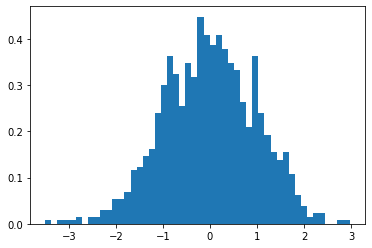

In [ ]:
plt.hist(univariate_normal.sample(1000), bins = 50, density = True)
plt.show()

In [ ]:
bi_nor_samples = bivariate_normal.sample(10000)

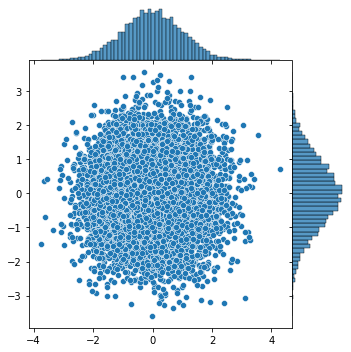

In [ ]:
g = sns.jointplot(
    x = bi_nor_samples[:,0], 
    y = bi_nor_samples[:,1], 
    space=0,
    height=5,
)

# **Step 2**

In [ ]:
def random_GMM_with_5_components(pi, mus, sigmas):
  '''
  pi : probabilities of hidden variables
  mus : means of clusters
  sigma : std of clusters
  '''
  
  gmm_with_5_comp = tfd.Mixture(
    cat = tfd.Categorical(probs = pi),
    components = [tfd.MultivariateNormalDiag(loc = mus[i], scale_diag = sigmas[i]) for i in range(mus.shape[0])] )
  
  return gmm_with_5_comp

In [ ]:
bivariate_gmmSampler = random_GMM_with_5_components(pi = tf.Variable([0.2,0.6,0.2]) ,mus = tf.Variable([bivariate_normal.sample().numpy(),
                                                                                      bivariate_normal.sample().numpy(),
                                                                                      bivariate_normal.sample().numpy()]),
                                  
                                  sigmas = tf.Variable([np.absolute(bivariate_normal.sample().numpy()),
                                                        np.absolute(bivariate_normal.sample().numpy()),
                                                        np.absolute(bivariate_normal.sample().numpy())]))

In [ ]:
gmm_samples = bivariate_gmmSampler.sample(1000)

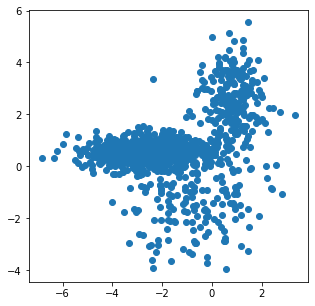

In [ ]:
plot_samples_2d(gmm_samples)

# **Define target_dist and base_dist**

In [ ]:
target_dist = bivariate_gmmSampler
base_dist = bivariate_normal

# **Question 1. (a) : Simple Normalizing Flow**

In [ ]:
class log_sigma_NN(layers.Layer):
  def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(log_sigma_NN, self).__init__(name="log_sigma_nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.log_sigma_layer = layers.Dense(input_shape, activation="tanh", name='log_sigma')

  def call(self, x):
      y = x
      for layer in self.layer_list:
          y = layer(y)
      log_sigma = self.log_sigma_layer(y)
      return log_sigma

In [ ]:
class mu_NN(layers.Layer):
  def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(mu_NN, self).__init__(name="mu_nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.mu_layer = layers.Dense(input_shape, name='mu')
  def call(self, x):
      y = x
      for layer in self.layer_list:
          y = layer(y)
      mu = self.mu_layer(y)
      return mu

In [ ]:
# If u is the sample from Pu(U), then T = sigma*u + mu is the transformation that we apply on 'u' so that T map Pu(U) to Px(X)

In [ ]:
class RNVP:
    def __init__(self, input_shape, flip):
        assert input_shape % 2 == 0
        
        input_shape = input_shape // 2
        mu_nn = mu_NN(input_shape)
        log_sigma_nn = log_sigma_NN(input_shape)
        
        x = keras.Input(input_shape)
        t = mu_nn(x)
        log_s = log_sigma_nn(x)

        self.mu_nn = keras.Model(x, [t], name = "mu_nn")
        self.log_s_nn = keras.Model(x, [log_s], name = "log_s_nn")
        self.flip = flip
        
    def _forward(self, u):
        u1, u2 = tf.split(u, 2, axis=-1)

        if self.flip == True:
          u1, u2 = u2, u1

        x1 = u1
        log_s = self.log_s_nn(u1)
        mu = self.mu_nn(u1)

        x2 = u2 * tf.exp(log_s) + mu 

        if self.flip == True:
          x1, x2 = x2, x1
        
        x = tf.concat([x1, x2], axis=-1)

        return x, log_s

    def _inverse(self, x):
        x1, x2 = tf.split(x, 2, axis=-1)

        if self.flip == True:
          x1, x2 = x2, x1
        
        u1 = x1
        log_s = self.log_s_nn(u1)
        mu = self.mu_nn(u1)
        
        u2 = (x2 - mu)/(tf.exp(log_s) + 0.000001)

        if self.flip == True:
          u1, u2 = u2, u1
        
        u = tf.concat([u1, u2], axis=-1)
        return u, log_s


In [ ]:
class RNVP_Chain():
  def __init__(self, chain_len = 4, flip = False):
    self.flip = flip
    self.chain_len = chain_len
  
    self.rnvp_chain = []
    for i in range(self.chain_len):
      self.rnvp_chain.append(RNVP(2,self.flip))
      self.flip = not self.flip

  def chain_inverse(self, x):
    u = x
    log_det_jacob_inv_transf = 0
    for i in range(self.chain_len-1,-1,-1):
      u, log_s = self.rnvp_chain[i]._inverse(u)
      log_det_jacob_inv_transf = log_det_jacob_inv_transf - log_s
    return u, log_det_jacob_inv_transf

  def chain_forward(self, u):
    x = u
    log_det_jacob_forward_transf = 0
    for i in range(self.chain_len):
      x, log_s = self.rnvp_chain[i]._forward(x)
      log_det_jacob_forward_transf = log_det_jacob_forward_transf + log_s
    return x, log_det_jacob_forward_transf

In [ ]:
RNVP_obj = RNVP_Chain(4)
# rnvp_chain = RNVP

In [ ]:
# print(RNVP_obj.chain_len)

In [ ]:
rnvp_chain = RNVP_obj.rnvp_chain

In [ ]:
def rnvp_loss(base_dist, log_det_jacob_inv_transf, u):
  return -tf.reduce_mean(base_dist.log_prob(u) + log_det_jacob_inv_transf)

In [ ]:
def check_nan(x):
  mat = tf.math.is_nan(x)
  return tf.math.count_nonzero(mat)

In [ ]:
def one_step(iteration, RNVP_obj, base_dist, target_dist, optimizer, batch_size):

    data_batch = target_dist.sample(batch_size)
    with tf.GradientTape() as tape:
      u, log_det_jacob_inv_transf = RNVP_obj.chain_inverse(data_batch)
      loss = rnvp_loss(base_dist, log_det_jacob_inv_transf, u)
    
    gradients = tape.gradient(loss, tape.watched_variables())
    
    found = False
    for grad in gradients:
        if(check_nan(grad).numpy() != 0):
          found = True
            
    if(not found):
      optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    else: 
      return 0

    print(iteration, " ----> ", loss.numpy())
    return 1

In [ ]:
def train_rnvp(epochs = 1, lr = 0.001, batch_size = 128, number_of_batches = 1000):
  optimizer = optimizers.Adam(learning_rate = lr)

  for i in range(number_of_batches):
    val = one_step(i, RNVP_obj, base_dist, target_dist, optimizer, batch_size)
    if(val == 0):
      break

In [ ]:
train_rnvp(1, .001, 128, 1000)

0  ---->  5.3044653
1  ---->  4.000891
2  ---->  3.8810418
3  ---->  3.7828393
4  ---->  3.953313
5  ---->  3.8390727
6  ---->  3.600141
7  ---->  3.7336237
8  ---->  3.8912988
9  ---->  3.636093
10  ---->  3.5435388
11  ---->  3.5219626
12  ---->  3.3860164
13  ---->  3.432836
14  ---->  3.6119437
15  ---->  3.4089532
16  ---->  3.400233
17  ---->  3.4429054
18  ---->  3.2286007
19  ---->  3.345423
20  ---->  3.235713
21  ---->  3.2951417
22  ---->  3.3949842
23  ---->  3.2935562
24  ---->  3.214097
25  ---->  3.3520374
26  ---->  3.1750643
27  ---->  3.3141837
28  ---->  3.4079614
29  ---->  3.3676333
30  ---->  3.1911058
31  ---->  3.0520515
32  ---->  3.0056498
33  ---->  3.1704535
34  ---->  3.094688
35  ---->  3.1128502
36  ---->  2.9964216
37  ---->  3.4135299
38  ---->  3.3656113
39  ---->  3.1467614
40  ---->  3.071423
41  ---->  3.1236355
42  ---->  2.9388778
43  ---->  3.1816652
44  ---->  3.0983753
45  ---->  3.0499187
46  ---->  2.9928074
47  ---->  3.161637
48  ---->  3.2

In [ ]:
train_rnvp(1, .000005, 100, 100)

0  ---->  2.0044506
1  ---->  1.8960004
2  ---->  1.9036409
3  ---->  2.1030064
4  ---->  2.0997667
5  ---->  1.7598397
6  ---->  2.273502
7  ---->  2.0814974
8  ---->  2.292907
9  ---->  2.2959456
10  ---->  1.7629826
11  ---->  1.9081734
12  ---->  1.9466399
13  ---->  2.1918893
14  ---->  1.8455336
15  ---->  2.055819
16  ---->  1.9034078
17  ---->  2.0086536
18  ---->  2.3900347
19  ---->  1.7795863
20  ---->  2.137541
21  ---->  1.8677695
22  ---->  1.9938717
23  ---->  2.0380063
24  ---->  1.9787141
25  ---->  2.1702282
26  ---->  1.6778258
27  ---->  1.6200415
28  ---->  2.3303652
29  ---->  2.1859891
30  ---->  2.0777805
31  ---->  2.2654488
32  ---->  2.2881777
33  ---->  2.0560873
34  ---->  1.9873809
35  ---->  1.8065015
36  ---->  2.015469
37  ---->  1.9109272
38  ---->  2.2675617
39  ---->  1.9731293
40  ---->  1.7895828
41  ---->  1.9023786
42  ---->  2.1204555
43  ---->  1.7339149
44  ---->  2.0447035
45  ---->  2.2478633
46  ---->  1.9343457
47  ---->  2.0422838
48  ---

In [ ]:
# gmm_samples = tf.cast(target_dist.sample(100000), tf.float32)

In [ ]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

## **Observations - In training of RNVP flow**
Problems Faced and how I tried to solve them?
1. learning stopped after 600 batches. So I tried to reduce the learning rate to tackle this, as the lr = 0.001 might be too large to go deep into the valley and hence the loss was fluctuating between the two values.

# **Q1. (a). part 1**

In [ ]:
test_samples_u = base_dist.sample(100000) #sampling 'u' from Pu(U)
test_samples_x, _ = RNVP_obj.chain_forward(test_samples_u) # apply the transformation T on each of the sample 'u' which is samples from Pu(U), so that they are converted to the samples of Px(X)
# plot_samples_2d(test_samples_x)

In [ ]:
def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

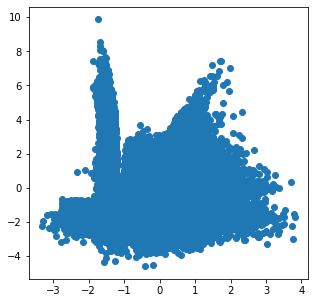

In [ ]:
plot_samples_2d(test_samples_x)

In [ ]:
# target_dist = bivariate_gmmSampler
# base_dist = 

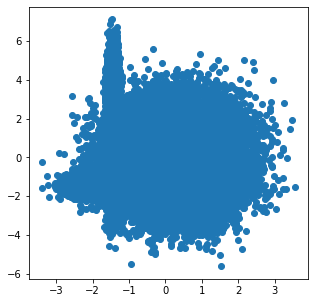

In [ ]:
target_direct_samples = target_dist.sample(100000)
plot_samples_2d(target_direct_samples)

## **Observations:**
1. RNVP with 4 layers/steps, is sufficiently good to model a GMM with 5 components
2. increasing the number of layers in RNVP flow, didn't have appreciable change in these plots
2. The plots of the target and model distribution are almost the same for most of the random GMMs that I created.
3. One thing that I noticed while personally, while running the training loop and RNVP for different GMMs is that when there are far away components of GMM separted, and each of them has very smalll variance, then the RNVP flow is not much accurate. Hence it is more accurate when the variance of each component if sufficiently large.

# **Q1. (a) part 2**

first sample from the target dist

here the target distribution is easy to sample from, hence we are using the samples directly

In [ ]:
target_dist_direct_samples = target_dist.sample(10000)

In [ ]:
# print(target_dist_direct_samples.shape)

then find the corresponding u for each x, that you sampled above using inverse trasnformation u = T^-1(x)

In [ ]:
u_samples, log_det_inverse_j = RNVP_obj.chain_inverse(target_dist_direct_samples)

In [21]:
# print(u_samples.shape, log_det_inverse_j.shape)

now use Px(x) = Pu(U) * e^(log_det_inverse_j) to calculate Px(x) and then plot them. 
These are the probabillites of x that we get from the trained model

In [ ]:
P_u_samples_prob = base_dist.prob(u_samples)

In [20]:
# print(P_u_samples_prob.shape)

In [ ]:
inverse_det_jacob = np.squeeze(np.exp(log_det_inverse_j))

In [19]:
# print(inverse_det_jacob.shape)

In [ ]:
model_probs_indirect = np.multiply(P_u_samples_prob, inverse_det_jacob)

In [18]:
# print(model_probs_indirect.shape)

In [ ]:
target_dist_probs_direct = target_dist.prob(target_dist_direct_samples)

taking the absolute diff between the probability values

In [ ]:
diff_probs = np.abs(target_dist_probs_direct - model_probs_indirect)
print(diff_probs.shape)

(10000,)


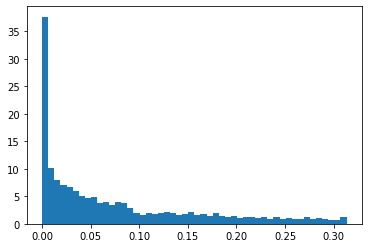

In [ ]:
plt.hist(diff_probs, bins= 50, density = True)
plt.show()

## **Observations:**
1. As there is a sharp peak at the value 0.00, it indicates that the model and the target probabilies match to a great extent, hence indicating that the RNVP flow with 4 layers was able to model the target distribution fairly well.
2. Also most of the peaks and the points lie near 0.00, again reflecting the high accuracy of RNVP model that I trained.
3. Maximum points lie within 0.05, indicating that most of the probability values from the model are very close to their actual value from the target distribution.


# **Question 1: (b) ---> Done using Planar Flow - Done using P\*(X) and not samples of P\*(X)**

can we declare w, b, c as tf.tensors? -- no, because then we wont' be able to change them by propagating gradients.

So we declare them as tf.Variable

In [ ]:
def check_nan(x):
  mat = tf.math.is_nan(x)
  return tf.math.count_nonzero(mat)

In [ ]:
# dimension of input -- u
Dim = 2

In [ ]:
w = tf.Variable(initial_value = tf.random.uniform(shape = [Dim, 1], dtype = tf.float32), trainable = True, name = 'w', dtype = tf.float32)
b = tf.Variable(initial_value = tf.random.uniform(shape = [1], dtype = tf.float32), trainable = True, name = 'b', dtype = tf.float32)
c = tf.Variable(initial_value = tf.random.uniform(shape = [Dim, 1], dtype = tf.float32), trainable = True, name = 'c', dtype = tf.float32)

In [ ]:
def forward_pass(u, w, b, c):
  #u is a vector here
  x = tf.add(u, tf.multiply(c, tf.math.tanh(tf.add(tf.linalg.matmul(w, u, transpose_a = True), b) )))
  return x

In [ ]:
# dum_u = tf.random.uniform(shape = [Dim, 1])

In [ ]:
# print(dum_u)

tf.Tensor(
[[0.4961251 ]
 [0.27957606]], shape=(2, 1), dtype=float32)


In [ ]:
# x = forward_pass(dum_u, w, b, c)
# print(x)

tf.Tensor(
[[0.9921765]
 [0.6509418]], shape=(2, 1), dtype=float32)


as math.abs() is not differentiable, then we can't use it here. so how to take care of this problem

how to ensure that det_jacob is positive

In [ ]:
def forward_det_jacob(u, w, b, c):
  h = tf.math.tanh(tf.add(tf.linalg.matmul(w, u, transpose_a = True), b) + 0.0000001) + 0.000001
  
  h_dash = tf.subtract(1.0, tf.multiply(h, h)) + 0.00000001
  
  det_jacob = tf.abs(tf.add(1.0, tf.multiply(h_dash, tf.matmul(c, w, transpose_a = True))))#tf.math.abs(tf.add(1, tf.multiply(h_dash, tf.matmul(c, w, transpose_a = True))))
  return det_jacob

In [ ]:
# det_jacob = forward_det_jacob(dum_u, w, b, c)
# print(det_jacob)

tf.Tensor([[1.8856192]], shape=(1, 1), dtype=float32)


In [ ]:
def planar_flow_loss(w, b, c, batch_size, base_dist, target_dist):
  samples = base_dist.sample(batch_size)
  
  log_target_dist = target_dist.log_prob(samples)
  
  log_det = []
  for sample in samples:
    #print(sample.shape, w.shape)
    sample = tf.expand_dims(sample, axis = 1)
    log_det.append(tf.math.log(forward_det_jacob(sample, w, b, c) + 0.000001))
  
  log_p_u = base_dist.log_prob(samples)

  loss = -1 * tf.reduce_mean(log_det + log_target_dist - log_p_u)

  return loss

In [ ]:
def one_step_planar_flow(w, b, c, base_dist, target_dist, optimizer, batch_size = 100, learning_rate = 0.001):
  with tf.GradientTape() as tape:
    lossval = planar_flow_loss(w, b, c, batch_size, base_dist, target_dist)

  gradients = tape.gradient(lossval, tape.watched_variables())
  
  found = False
  for grad in gradients:
      if(check_nan(grad).numpy() != 0):
        found = True
          
  if(not found):
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
  else: 
    return 0

  print(lossval.numpy())
  return 1

In [ ]:
def train_planar_flow(n_iter = 1000):
  optimizer = optimizers.Adam(learning_rate = 0.001)
  for _ in range(n_iter):
    print(_)
    val = one_step_planar_flow(w, b, c, bivariate_normal, bivariate_gmmSampler, optimizer)
    if(val == 0):
      print("Nan found")
      break

In [ ]:
train_planar_flow()

0
3.679518
1
3.9484437
2
3.719111
3
3.75935
4
3.528953
5
3.8867798
6
3.652553
7
3.8982618
8
3.6127899
9
3.843528
10
3.5806844
11
3.6322587
12
3.7388544
13
3.7176907
14
3.865661
15
3.8302894
16
3.8075812
17
3.7086039
18
3.7131667
19
3.813359
20
3.7498794
21
3.4749923
22
3.6938972
23
3.900779
24
3.7791708
25
3.6640835
26
3.5443294
27
3.4163477
28
3.7715688
29
3.6730895
30
3.8851454
31
3.5447938
32
3.4473114
33
3.6387718
34
3.6175272
35
3.6894
36
3.672353
37
3.4231148
38
3.4582934
39
3.634896
40
3.7443516
41
3.8510492
42
3.5056195
43
3.873704
44
3.5862427
45
3.5662477
46
3.730229
47
3.7314453
48
3.5148883
49
3.5562406
50
3.5637484
51
3.5580602
52
3.526634
53
3.4756134
54
3.7846923
55
3.6348777
56
3.7927668
57
3.5647087
58
3.7750258
59
3.5427122
60
3.696093
61
3.5609715
62
3.553332
63
3.7830806
64
3.4234567
65
3.4153152
66
3.508072
67
3.6102695
68
3.5338032
69
3.5652149
70
3.6682203
71
3.432744
72
3.5236578
73
3.5707462
74
3.3435445
75
3.518693
76
3.7269168
77
3.5186214
78
3.4053047
79
3.7

## **Observations and Difficulties**
1. While implementing the flow, I didn't get as to how I should ensure that determinant of jacobian is positive -- Maybe that's the reason why my model is not training well.
2. I can do tf.abs(det_jacob) but that would make this whole thing non-differentiable. Still I did this while implementing.
3. Losses are not converging during the training.
4. Inverse mapping cannot be obtained for this kind of flow, hence Q1(a) can't be implemented using this flow.


# **Q1 (b) part 1**

In [ ]:
# print(w, b, c)

In [ ]:
data = []

new_samples = bivariate_normal.sample(1000)
for sample in new_samples:
  sample = tf.expand_dims(sample, 1)
  data.append(forward_pass(sample, w, b, c))

In [ ]:
data = np.asarray(data)

In [17]:
# print(data.shape)

In [ ]:
data = tf.squeeze(data)

In [16]:
# print(data.shape)

In [ ]:
def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

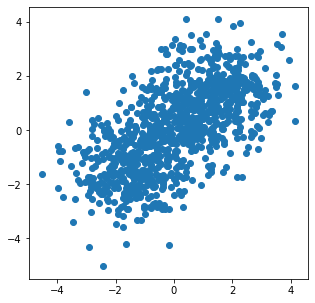

In [ ]:
plot_samples_2d(data)

Observations: 
1. The expressibility of Planar Flow is very less as compared to RNVP flow.
2. Also as only one layer of Planar Flow is used, whereas in case of RNVP flow multiple layers were used, which led to more expressibility of RNVP flows.

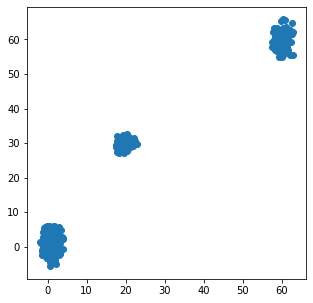

In [ ]:
target_direct_samples = bivariate_gmmSampler.sample(1000)
plot_samples_2d(target_direct_samples)

**Observations:**
1. Planar flow is not sufficiently powerful enough to model complex distributions like GMM or 
2. Given only P_star which cannot be sampled from, the the model has not much data/power to given an accurate transformation.
3. This also indicates that training a flow with the samples from target distribution is better than training it using the actuall pdf which is difficult to sample from.

# **Q1 (b) part 2**

1. Here we don't have access to the samples of target_dist i.e. we can't use target_dist.sample(), as it is specified that target_dist is very difficult to sample from but it is easy to find target_dist.prob(x)
2. So here we will sample u ~ Pu(U) from the base_dist, and then apply the transformation x = T(u), to find the sample x.
3. Then calculate target_dist.prob(x). This is equivalent to using ptarget.prob(x)
4. Then use Px(x) = Pu(U) * det, to estimate the probabilities using the model. This is equivalent to using the trained model.

In [ ]:
base_dist_samples = base_dist.sample(1000)

In [ ]:
x = []

for sample in base_dist_samples:
  sample = tf.expand_dims(sample, 1)
  x.append(forward_pass(sample, w, b, c))

In [ ]:
x = np.squeeze(np.asarray(data))

In [15]:
# print(x.shape)

Now we can find the probabilities using the two methods
<br>
Probabilitie using the ptarget.prob

In [ ]:
prob_using_ptarget = np.expand_dims(bivariate_gmmSampler.prob(x), 1)

In [ ]:
# print(prob_using_ptarget)

In [ ]:
# print(x)

In [ ]:
bivariate_gmmSampler.prob(x[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.04320634>

### Probabiliese using the model

In [ ]:
jacob_det = []

for sample in base_dist_samples:
  sample = tf.expand_dims(sample, 1)
  #print(np.squeeze(forward_det_jacob(sample, w, b, c)).shape)
  jacob_det.append(np.squeeze(forward_det_jacob(sample, w, b, c)))

In [ ]:
jacob_det = np.squeeze(np.asarray(jacob_det))

In [13]:
# print(jacob_det.shape)

In [ ]:
model_probs = np.expand_dims(base_dist.prob(base_dist_samples), 1) * np.expand_dims(jacob_det, 1)

In [14]:
# print(model_probs.shape)

### now finding the difference

In [ ]:
# print(model_probs)

In [ ]:
# print(prob_using_ptarget)

In [ ]:
prob_diff_q1_b = np.absolute(model_probs - prob_using_ptarget)

In [ ]:
# indexes_to_include = np.logical_not(np.isnan(prob_diff_q1_b))

In [ ]:
# prob_diff_q1_b = prob_diff_q1_b[indexes_to_include]
# # prob_using_ptarget = prob_using_ptarget[indexes_to_include]

In [ ]:
print(prob_diff_q1_b.shape)

(1000, 1)


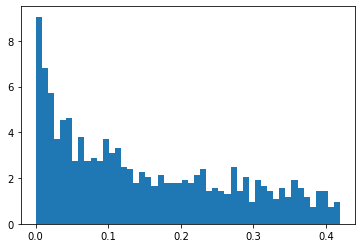

In [ ]:
plt.hist(prob_diff_q1_b, bins = 50, density = True)
plt.show()

**Observations**
1. Here the max value on the x-axis is 0.4 which is fairly large in comparison to the max value on x-axis of Q1(a) part 2, which had max value of 0.03.
2. Also very less of the points are clustered around 0.00, again indicating that the for most of the samples probability difference is large as compared to Q1(a) part 2. 
3. Comparing the plots from Q1a part 2 and q1b part 2, one can clearly infer that the model in Q1a is superior as the difference of probability values from the model and target distribution is less.

# **YOUR OBSERVATIONS:**

### Q1 a. Wrote below the plots
Here in this part I have used RNVP flow, and as there was no Nan error, hence the training was complete and the flow gave very good results on most of the GMMs that I tried.
Also the estimated probabilities and importance sampling this was fairly good that Q1(b)

### Q1 b. Wrote below the plots
1. Challenge 1: Nan gradients while training.
2. Solution: reduced the learning rate

### Q1 c. Didn't do


# Q2: Importance Sampling
Use the codes and models of Q1 to solve this problem
1. Assume you do not have access to `ptarget.sample()` but only to `ptarget.prob()`. Estimate $E[x^2]$ using the NF models of Q1a and Q1b. Write your obervations in the markdown block below the plots. [5 marks]
2. Evaluation: Now using the complete class `ptarget`, find $E[x^2]$ and compare it with the value computed in Q2.1. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

## Q2. (1) Estimation of E[x^2] using target_dist.prob() only

### **Explanation of the process**

estimate = 1/n * Simga(f(xi) * (p(xi)/q(xi))

1. let p(x) = target_dist, which is very hard to sample from, but p.prob(x) is easy to calc
2. let q(x) = trained_model, which is easy to sample from and also very close to p(x) i.e. close to the target_dist
<br>

We can choose either of the trained models from Q1 (a) and Q1 (b) as our q(x).
<br>

3. For Q1. (b) To sample from q(x) we could just sample from Pu(U) and then apply the transformation x = T(u)

3. now sample x ~ q(x), calc p.prob(x) and q.prob(x).
<br>
To calc q.prob(x) you would have to make the use of model and the relation Px(x) = Pu(U) * det()^-1 
4. Also calc f(x) = x^2 for this x sampled from q(x).
5. find the sum of f(x) * (p(x) / q(x)) over all these x's sampled from q(x).
6. Take average

### **Using the trained model from Q1.(a) to do Importance Sampling**

sample from the base distribution

In [ ]:
x = target_dist.sample(10000)

In [ ]:
p_probs = np.expand_dims(target_dist.prob(x), 1)
print(p_probs.shape)

(10000, 1)


In [ ]:
u, log_det_jacob_inv_transf = RNVP_obj.chain_inverse(x)

In [11]:
# print(u.shape, log_det_jacob_inv_transf.shape)

In [12]:
# print(base_dist.prob(u).shape)

In [ ]:
log_det_jacob_inv_transf

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[ 1.6508317 ],
       [ 1.9295774 ],
       [ 1.8082101 ],
       ...,
       [-0.09262273],
       [-1.2212701 ],
       [ 1.2211505 ]], dtype=float32)>

In [ ]:
q_probs = np.multiply(np.expand_dims(base_dist.prob(u), axis = 1), tf.math.exp(log_det_jacob_inv_transf))

In [ ]:
print(q_probs)

[[0.45099363]
 [0.2815641 ]
 [0.5119082 ]
 ...
 [0.01717807]
 [0.01895076]
 [0.00496134]]


In [ ]:
ratio = np.divide(p_probs, q_probs)
print(ratio.shape)

(10000, 1)


In [ ]:
f_x = np.multiply(x, x)

In [10]:
# ratio = tf.clip_by_value(ratio, -100, 100)
# print(ratio)

In [9]:
# print((ratio * f_x).shape)

In [8]:
# print(f_x)

In [ ]:
approx_1 = np.mean(np.hstack((ratio, ratio)) * f_x, 0)

In [ ]:
print(approx_1)

[3.1438634 5.0335345]


#### **Observations for Q2 part 1 using Q1 (a)**

**Reason for large values(sometimes of the order of 1000 times the value obtained from Q2.part 2) when estimating using importance sampling:** 
1. **Occurs When** - This error is pre-dominant for some certain kinds of distributions only.
2. When teh GMM has components which have very less variance and are separated across a lot of space, then the value obtained by this method is very large.
3. **Reason** - May there are way more outliers when were randomly sampling from the ptarget(this may happen when ptarget is too much concentrated in small regions, which the modelled distribution is not so much densely concentrated in small regions), which give very small values of q(x), hence inflating the value of the approximation.
4. Also for distributions in which this error is not too much, yet the value obtained by this method will be somewhat large(even if by small margin) than the value obtained by Q2 part 2, because q(x) would lie mostly < 1, hence increasing the value of approximation.

1. here we can't directly sample from distribution as that is not allowed

### **Using the trained model from Q1. (b) to do Importance Sampling**

In [ ]:
base_samples = base_dist.sample(1000)

x = []
det_jacob_forward_transf = []

for sample in base_samples:
  x_ = forward_pass(np.expand_dims(sample, 1), w, b, c)
  det_jacob_forward_transf_ = forward_det_jacob(np.expand_dims(sample,1 ), w, b, c)
  #print(x_.shape)
  x.append(x_)
  det_jacob_forward_transf.append(det_jacob_forward_transf_)

In [1]:
# print(base_samples.shape)

In [ ]:
x = np.squeeze(np.asarray(x))
det_jacob_forward_transf = np.expand_dims(np.squeeze(np.asarray(det_jacob_forward_transf)), 1)

In [2]:
# print(x.shape, det_jacob_forward_transf.shape)

In [ ]:
real_probs = target_dist.prob(x)

In [3]:
# print(real_probs.shape)

In [ ]:
estimated_prob = np.expand_dims(base_dist.prob(base_samples), 1) * np.power(det_jacob_forward_transf, -1)

In [4]:
# print(estimated_prob.shape)

In [ ]:
ratio = np.divide(np.expand_dims(real_probs, 1), estimated_prob)

In [ ]:
f_x = np.multiply(x, x)

In [6]:
# print(f_x.shape)

In [ ]:
# # ratio = tf.clip_by_value(ratio, -100, 100)
# print(ratio)

In [5]:
# print((ratio * f_x).shape)

In [7]:
# print(f_x)

In [ ]:
approx_2 = np.mean(np.hstack((ratio, ratio)) * f_x, 0)

In [ ]:
print(approx_2)

[nan nan]


## **Observations**
1. The reason for Nan approximation is that the model is not trained well, so p(x)/q(x) might explode to infinity, giving the Nan error.
2. This error can't be resolved without traning the planar flow well.
3. The logic applied here in this code is correct, but the results are unexpected ones, just because the planar flow can't be trained well.

## Q2. (2) using the complete class ptarget, find  E[x2]

Here we can freely sample from the target_dist and also use target_dist.prob
1. Sample from target_dist using x = target_dist.sample()
2. Use this sample to calc target_dist.prob(x)
3. calc x^2
4. calc average(x^2 * target_dist.prob(x)) over a large number of samples

Now compare the two values from Q2(1) and one value from Q2(2). This reflects the expressive power of flows to model the target_distribution.

In [ ]:
direct_target_samples = target_dist.sample(10000)

In [ ]:
direct_target_probs = np.expand_dims(target_dist.prob(direct_target_samples), 1)

In [ ]:
f_x = np.multiply(direct_target_samples, direct_target_samples)

In [ ]:
print(f_x.shape)

(10000, 2)


In [ ]:
direct_target_approx = np.mean((f_x * direct_target_probs), axis = 0)

In [ ]:
print(direct_target_approx.shape, direct_target_approx)

(2,) [0.8079961  0.90798515]


## YOUR OBSERVATIONS:

### Q2.1
#### **Observations for Q2 part 1 using Q1 (a)**

**Reason for large values(sometimes of the order of 1000 times the value obtained from Q2.part 2) when estimating using importance sampling:** 
1. **Occurs When** - This error is pre-dominant for some certain kinds of distributions only.
2. When teh GMM has components which have very less variance and are separated across a lot of space, then the value obtained by this method is very large.
3. **Reason** - May there are way more outliers when were randomly sampling from the ptarget(this may happen when ptarget is too much concentrated in small regions, which the modelled distribution is not so much densely concentrated in small regions), which give very small values of q(x), hence inflating the value of the approximation.
4. Also for distributions in which this error is not too much, yet the value obtained by this method will be somewhat large(even if by small margin) than the value obtained by Q2 part 2, because q(x) would lie mostly < 1, hence increasing the value of approximation.


### Q2.2
1. Even if I increase the no of samples from 1000 to 10000 the value stays at roughly the same value, suggesting that this is indeed the estimated value of the E[x^2]
2. If no of samples if increased beyond a certain minimum value, then the estimated value no longer changes, suggesting that with suffiecient samples, the estimate is correct to a large degree.
3. Also upon multiple experiments this comes out to be smaller than the value obtained in Q2 part 1, just because it is not divided by q(x) which is < 1 for most of the time, rendering p(x)/q(x) slightly larger than p(x).